In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rafael Flock (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# UQ for stochastic optical reconstruction microscopy

### Rafael Flock (raff@dtu.dk)

**Notice** You need CUQIpy-PyTorch to run this notebook.

In this case study, we perform uncertainty quantification for stochastic optical reconstruction microscopy (STORM). STORM is a super-resolution microscopy method based on single-molecule stochastic switching, where the goal is to detect molecule positions in live cell imaging. The image is obtained by a microscope detecting the photon count of the (fluorescence) photoactivated molecules. The original problem is solved in [1] by a determistic method. In this notebook, we perform uncertainty quantification in the Bayesian context [2].


In [2]:
import cuqi
import torch
from cuqi.distribution import JointDistribution
from cuqipy_pytorch.distribution import Gaussian, Laplace
from cuqipy_pytorch.sampler import NUTS

import numpy as np
import scipy
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  1.0.0


In [4]:
np.random.seed(0)
torch.manual_seed(0)

## 1. Problem description

We start by collecting some parameters in a dictionary. These parameters will be used in creating our groundtruth image and describing our noise model.

In [5]:
# parameters
par = \
{'N': 50, # number of molecules
 's_data': 32, # side length of data image
 's_mol': 24, # side length of area in data image where molecules are located
 'R': 4, # super-resolution factor
 'mode': 3000, # mode of lognormal distribution of molecule photon count
 'ph_back': 70, # photon background count
 'noise_std': 30, # standard deviation of noise
 'pad_width': 1, # for boundary conditions of blurring kernel of instrument
 'ext_mode': 'periodic', # boundary condition of blurring kernel
 'lognorm_std': 0.417, # standard deviation of lognormal distribution of photon count
 'ind_mol_seed': 0, # seed for generation of true molecule positions
 'N_pho_seed': 1, # seed for generation of true photon count of molecules
 'noise_seed': 2, # seed for noise
 'delta': 1.275, # rate parameter of Laplace prior
}

We also define two functions that help us to switch between image and vector view of our data.

In [6]:
# ravel/unravel image/vector in column-wise fashion
rav = lambda x: np.ravel(x, order='F')
unrav = lambda x, s: np.reshape(x, newshape=(s,s), order='F')

### Ground truth image

Let's break down the process to generate the ground-truth image step by step:

- generate true molecule positions: the exact positions of 50 molecules are first generated by drawing samples from a uniform distribution.

- generate true molecule counts: The exact molecule count/intensity is simulated from a lognormal distribution of given mean and standard deviation.

- place molecules in super-resolution image: the generated molecule counts are then placed in an image of higher resolution.

In [7]:
# true molecule positions
x_im_truth = np.zeros((par['s_mol']*par['R'],
                       par['s_mol']*par['R']))
np.random.seed(par['ind_mol_seed'])
ind_mol_crop = np.random.choice(np.arange(x_im_truth.size),
                                size=par['N'],
                                replace=False) # indices of molecule positions

# true photon counts
# (mean of lognormal distribution based on [1])
lognorm_mean = np.log(par['mode']) + par['lognorm_std']**2 
np.random.seed(par['N_pho_seed'])
N_pho = lognorm.rvs(loc=0, s=par['lognorm_std'],
                    scale=np.exp(lognorm_mean),
                    size=par['N']) # photons count of molecules

# place photons in super-resolution image
x_im_truth[np.unravel_index(ind_mol_crop,
                            shape=(x_im_truth.shape[0], x_im_truth.shape[1]),
                            order='F')] = N_pho
x_im_truth = np.pad(x_im_truth,
                    (par['s_data']-par['s_mol'])//2*par['R'],
                    mode='constant',
                    constant_values=0) # no molecules in this area
# (indices of molecules in column-stacked vector)
ind_mol = np.nonzero(rav( (x_im_truth > np.zeros((par['s_data']*par['R'],
                                                  par['s_data']*par['R'])))
                                                  ) )[0]

### Forward operator and data
We now import the full forward operator from external file. The forward operator is represented by a matrix $A_{\text{mat}}$ that maps the true image of molecules to the data image $y$, so $y_{\text{truth}}=A_{\text{mat}}x$.

In [8]:
A_mat = scipy.sparse.load_npz("A_mat.npz")

The synthetic data is then generated by adding Gaussian noise of a specific standard deviation to the data image, so $y = y_{\text{truth}} + \text{noise}$. Here we also show the SNR (signal-to-noise-ratio).

In [10]:
# true data
y_truth = A_mat @ rav(x_im_truth)

# noise
np.random.seed(par['noise_seed'])
N_pho_noise = norm.rvs(scale=par['noise_std'], size=par['s_data']**2)
y = y_truth + N_pho_noise
print(f"SNR={np.linalg.norm(y)/np.sqrt(y.size)/par['noise_std']}") # signal-to-noise-ratio
y = torch.tensor(y, dtype=torch.float32)

SNR=57.79430039788669


To have a better view of the problem, we plot the groundtruth and the data image, and the inverse problem will be to estimate to the groundtruth from the data image.

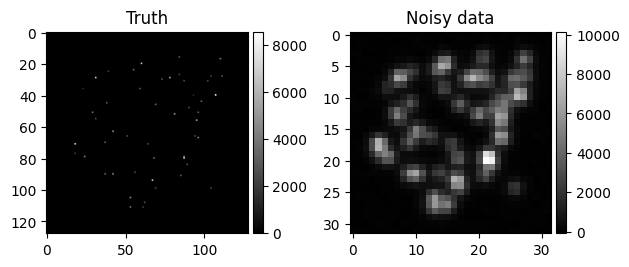

In [11]:
## plot truth and data
fig, ax = plt.subplots(ncols=2)

# truth
im = ax[0].imshow(x_im_truth, cmap='gray')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Truth')
fig.colorbar(im, cax=cax, orientation='vertical')

# data
im = ax[1].imshow(unrav(y, par['s_data']), cmap='gray')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[1].set_title('Noisy data')
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

## 2. Smoothed Laplace prior

The Laplace prior is a type of prior distribution that is frequently used in Bayesian statistics. It is characterized by a peak at zero and exponential decay for both positive and negative values, making it a good choice for promoting sparsity: parameters with a Laplace prior tend to be either significantly non-zero or exactly zero.

One difficulty of working with the Laplace prior is that its PDF (probability density function) is not differential arround zero and this non-differentiability hinders the use of gradient-based MCMC samplers. Here we use the "smoothed" Laplace distribution which approximates the Laplace distribution but is equipped with a continuous gradient method. More details on the smoothed Laplace distribution can be found in a separate [notebook](https://github.com/CUQI-DTU/CUQIpy-User-Showcase/blob/main/007_smoothed_Laplace/smoothed_laplace.ipynb).

In [12]:
class LaplaceSmoothed(cuqi.distribution.Distribution):
    def __init__(self, location, scale, beta, **kwargs):
        super().__init__(**kwargs)
        self.location = location
        self.scale = scale
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = torch.tensor([x])
        return torch.sum(torch.log(0.5/self.scale) - torch.sqrt((x-self.location)**2+self.beta)/self.scale)
    
    def gradient(self, x):
        x.requires_grad = True
        x.grad = None
        Q = self.logpdf(x)     # Forward pass
        Q.backward()           # Backward pass
        return x.grad

    def _sample(self,N=1,rng=None):
        return None

## 3. Dimension-reduced likelihood

The dimension of the inverse problem is of size $16384=128\times128$, which is challenging for even gradient-based samplers. In [2], we propose a method, the Certified Coordinate Selection, to reduce the dimension of the problem. In brief, we select the components in $x$ that contribute the most to the posterior relatively to the prior. To this end, we employ the coordinate splitting
$$x = (x_{\mathcal{I}}, x_{\mathcal{I}^c}),$$
where $x_{\mathcal{I}}$ are the selected coordinates. Then, we replace the likelihood by a ridge approximation $x_{\mathcal{I}} \mapsto \tilde{\pi}(x_{\mathcal{I}}|y)$ such that the posterior reads $\pi(x|y) \propto \tilde{\pi}(x_{\mathcal{I}}|y) \pi_0(x)$. With a proper choice of the set $\mathcal{I}$, an optimal posterior approximation (with respect to the Hellinger distance) can be constructed on $x_{\mathcal{I}}$. The ridge approximation of the likelihood function reads $\tilde{\pi}(x_{\mathcal{I}}|y) \propto \exp( -\frac{\lambda}{2} \| y - A (x_{\mathcal{I}}, x_{\mathcal{I}^c=0})\|^2)$, where $\lambda$ is the noise precision of the iid Gaussian noise. Note that $x_{\mathcal{I}}$ is not computed in this notebook, but loaded from a file. We refer the reader to [2] for further information.

The selected coordinates $x_{\mathcal{I}}$ are plotted in the following plot as black pixels.

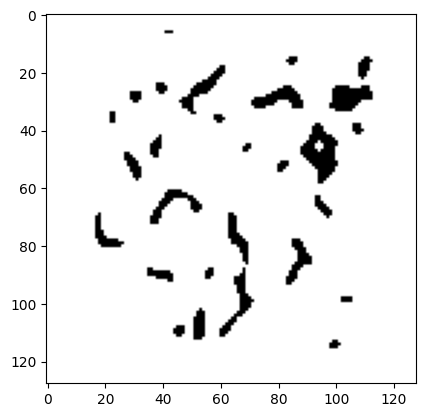

In [13]:
# truth
selected_set = np.load('I.npy')
x_selected_set = np.zeros(x_im_truth.shape)
fig = plt.figure()

temp = rav(x_selected_set)
temp[selected_set] = 1
x_selected_set = unrav(temp, 128)
plt.imshow(x_selected_set, cmap='gray_r')

## 4. Posterior sampling with CUQIpy
With the above description of the smoothed Laplace prior and reduced likelihood, it is time to have a look at how to do the posterior sampling with CUQIpy. Particularly, we will use the NUTS sampler from the CUQIpy-PyTorch extension.

In [14]:
# prior
d = len(selected_set) # dimension of the problem after reduction
beta = 1e-5 # smoothing parameter
X = LaplaceSmoothed(location = torch.zeros(d), scale=1/par['delta']*torch.ones(d), beta=beta)

The reduced forward solver can be defined by selecting specific columns of the imported full matrix. We also utilize a PyTorch tensor for compatibility with PyTorch operations.

In [15]:
A_reduced_coo = A_mat[:,selected_set].tocoo()
values = A_reduced_coo.data
indices = np.vstack((A_reduced_coo.row, A_reduced_coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = A_reduced_coo.shape

A_reduced_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [16]:
Y = Gaussian(lambda X: torch.matmul(A_reduced_torch, X),
             cov= par['noise_std']**2*torch.ones(A_reduced_torch.shape[0]))

Then we can define our joint distribution and condition it on the data:

In [17]:
X_Y = JointDistribution(X, Y)
print(X_Y)

p = X_Y(Y=y)

JointDistribution(
    Equation: 
	p(X,Y) = p(X)p(Y|X)
    Densities: 
	X ~ CUQI LaplaceSmoothed.
	Y ~ CUQI Gaussian. Conditioning variables ['X'].
)


With the posterior object `p` defined, we are ready to draw samples from `p`. As we said earlier, the prior is now equipped with gradient method, we can use gradient-based samplers to draw samplers from the posterior. Here we use the NUTS sampler.

In [18]:
torch.manual_seed(0)
nuts_sampler = NUTS(p)

In [ ]:
nuts_samples = nuts_sampler.sample(5000, 1000)

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'X190'}>,
        <Axes: title={'center': 'X190'}>],
       [<Axes: title={'center': 'X252'}>,
        <Axes: title={'center': 'X252'}>],
       [<Axes: title={'center': 'X494'}>,
        <Axes: title={'center': 'X494'}>],
       [<Axes: title={'center': 'X709'}>,
        <Axes: title={'center': 'X709'}>],
       [<Axes: title={'center': 'X861'}>,
        <Axes: title={'center': 'X861'}>]], dtype=object)

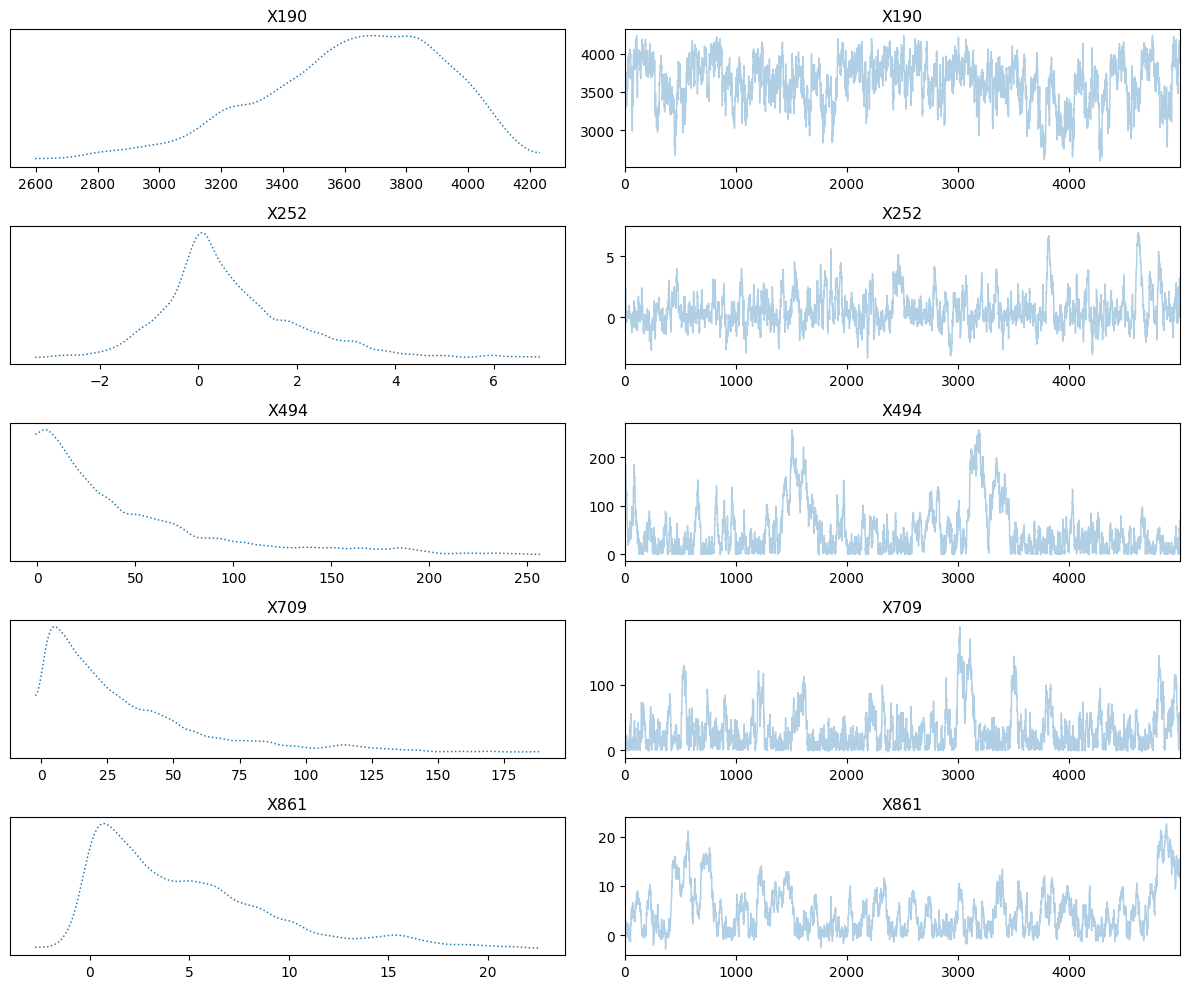

In [20]:
nuts_samples['X'].plot_trace()

Recall that we are only performing posterior sampling on the selected set of pixels. To visualize the posterior mean, we can insert these sampled values back into a vector of the same size as the original image, leaving the rest of the entries as zero.

Text(0.5, 1.0, 'Posterior mean of NUTS samples')

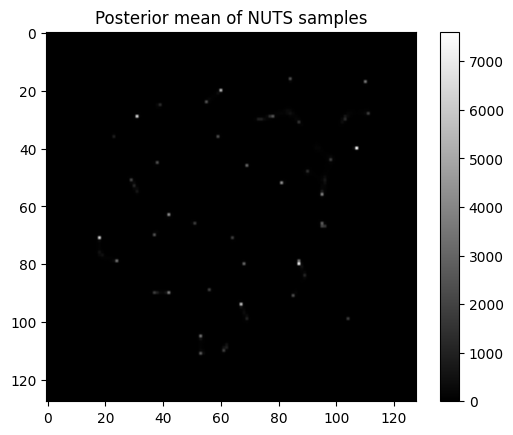

In [21]:
x_post = np.zeros(16384)
x_post[selected_set] = nuts_samples['X'].mean()
plt.imshow(unrav(x_post, 128), cmap='gray')
plt.colorbar()
plt.title("Posterior mean of NUTS samples")

We can also visualize a particular sample from the posterior, specifically, the last sample from the NUTS samples. Similar to viewing the posterior mean, we place this sample into a vector of the same size as the original image, while the remaining pixels are drawn from the prior distribution.

Text(0.5, 1.0, 'The last NUTS sample')

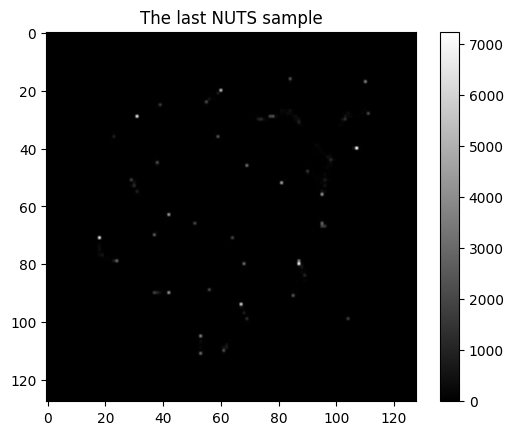

In [22]:
x_laplace = Laplace(0, 1/par['delta'])
x_last_sample = x_laplace.sample(16384).samples.flatten().numpy()
x_last_sample[selected_set] = nuts_samples['X'].samples[:,-1]
plt.imshow(unrav(x_last_sample, 128), cmap='gray')
plt.colorbar()
plt.title("The last NUTS sample")

Compared to the ground truth, the posterior mean of the MCMC sampling recovers the signal quite well. Most values converge to near zero, indicating areas with little to no signal. However, a few values converge to higher extremes, highlighting regions where the signal is present. This contrast effectively captures the underlying structure of the image, demonstrating the ability of the Laplace prior in promoting sparsity in signals.

We note that the efficient sampling for such a problem is made possible with a combined use of several techniques. The smoothed Laplace prior ensures that the solution remains sparse and interpretable, the reduced likelihood keeps the computational demands manageable, and NUTS guarantees robust and efficient exploration of the posterior distribution. Together, these methods enable the precise reconstruction of the signal, as evidenced by the posterior mean, which closely aligns with the ground truth while highlighting significant features against a mostly zero-valued background.

## References

[1]
Zhu, L., Zhang, W., Elnatan, D., Huang, B.: Faster STORM using compressed sensing. Nature Methods 9(7), 721–723 (2012) https://doi.org/10.1038/nmeth.1978

[2]
Flock, R., Dong, Y., Uribe, F., & Zahm, O.: Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior. Statistics and Computing. Under Review (2023). https://doi.org/10.21203/rs.3.rs-3471448/v1 